In [1]:
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image
from sklearn.model_selection import train_test_split
from pyspark.sql import SparkSession
import cv2
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.ml.feature import StringIndexer

In [2]:

# SparkSession start
spark = SparkSession.builder \
    .appName("ImageProcessing") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \  #Connecting wih HDFS system
    .getOrCreate()

print("CNN adventure has been started :)")


CNN adventure has been started :)


25/03/20 18:36:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Loading image files from HDFS in binary format
### Binary format allows images to be loaded as raw (unprocessed) data.

In [3]:
# Path in Hdfs
image_path = "hdfs://localhost:9000/plant_dataset/plant_dataset"


parquet_output_path = "hdfs://localhost:9000/assessment1/plant_dataset_parquet4"

# Loading pictures
image_df = spark.read.format("binaryFile") \
    .option("recursiveFileLookup", "true") \
    .load(image_path)



# Filtereing Jpg files
image_df = image_df.filter(image_df.path.endswith(".JPG") | 
                           image_df.path.endswith(".JPEG") | 
                           image_df.path.endswith(".jpg") | 
                           image_df.path.endswith(".jpeg"))


In [4]:
image_df.printSchema()


root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [5]:
# how many picture
print("Toplam JPG sayısı:", image_df.count())



Toplam JPG sayısı: 2230


##### We have total 2230 pictures at the moment

In [6]:
def get_image_shape(content):
    image_array = np.frombuffer(content, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return (image.shape[0], image.shape[1], image.shape[2])  # (Height, Width, Channels)

shape_schema = StructType([
    StructField("height", IntegerType(), True),
    StructField("width", IntegerType(), True),
    StructField("channels", IntegerType(), True)
])

@udf(shape_schema)
def image_shape_udf(content):
    return get_image_shape(content)

image_df = image_df.withColumn("image_shape", image_shape_udf(image_df["content"]))
image_df.select("path", "image_shape").show(5, truncate=False)


+---------------------------------------------------------------------------------+-------------+
|path                                                                             |image_shape  |
+---------------------------------------------------------------------------------+-------------+
|hdfs://localhost:9000/plant_dataset/plant_dataset/Tomato___healthy/image (38).JPG|{256, 256, 3}|
|hdfs://localhost:9000/plant_dataset/plant_dataset/Tomato___healthy/image (3).JPG |{256, 256, 3}|
|hdfs://localhost:9000/plant_dataset/plant_dataset/Tomato___healthy/image (72).JPG|{256, 256, 3}|
|hdfs://localhost:9000/plant_dataset/plant_dataset/Tomato___healthy/image (12).JPG|{256, 256, 3}|
|hdfs://localhost:9000/plant_dataset/plant_dataset/Tomato___healthy/image (70).JPG|{256, 256, 3}|
+---------------------------------------------------------------------------------+-------------+
only showing top 5 rows



### This code extracts the dimensions (height, width, number of channels) of images on HDFS. 
### The content of each image is processed in binary format, and the dimensions are obtained using OpenCV and added as a new column.
### As a result, the dimension information of each image ( 256x256x3) is displayed.

In [7]:
from pyspark.sql.functions import split

# Path’ten class label çıkarma
image_df = image_df.withColumn("label", split(image_df["path"], "/").getItem(5))  #5.indeks'te olduğu için

# Kaç farklı class olduğunu göster
print(f"Toplam Class Sayısı: {image_df.select('label').distinct().count()}")

# Class dağılımını göster
image_df.groupBy("label").count().show()

Toplam Class Sayısı: 23


+--------------------+-----+
|               label|count|
+--------------------+-----+
|    Tomato___healthy|   72|
|Pepper,_bell___Ba...|   84|
|   Apple___Black_rot|   72|
|Tomato___Target_Spot|   59|
|    Potato___healthy|   60|
|Tomato___Spider_m...|   95|
|Tomato___Septoria...|  324|
|Tomato___Tomato_m...|  373|
|Potato___Early_bl...|   60|
|Pepper,_bell___he...|   71|
|    Cherry___healthy|   72|
|Strawberry___Leaf...|   84|
|  Apple___Apple_scab|   72|
|Strawberry___healthy|   60|
|Tomato___Early_bl...|   60|
|Potato___Late_blight|   60|
|Tomato___Tomato_Y...|   60|
|     Apple___healthy|   72|
|Tomato___Late_blight|   84|
|  Tomato___Leaf_Mold|  108|
+--------------------+-----+
only showing top 20 rows



## Label Encoding

In [8]:
from pyspark.sql.functions import when, lit
from pyspark.sql import SparkSession

# Benzersiz sınıfları al
class_labels = image_df.select("label").distinct().rdd.flatMap(lambda x: x).collect()

# Label -> Index eşleşmesi oluştur
label_to_index = {label: idx for idx, label in enumerate(sorted(class_labels))}

# Spark’a uygun hale getirmek için Case-When koşulları oluştur
label_index_expr = when(lit(False), -1)  # Başlangıç değeri
for label, idx in label_to_index.items():
    label_index_expr = label_index_expr.when(image_df["label"] == label, lit(idx))

# Yeni sütunu ekleyerek label'ları sayısal hale getir
image_df = image_df.withColumn("label_index", label_index_expr)

# İlk 10 satırı göster
image_df.select("label", "label_index").distinct().show(truncate=False)


+---------------------------------------------+-----------+
|label                                        |label_index|
+---------------------------------------------+-----------+
|Tomato___healthy                             |22         |
|Apple___Black_rot                            |1          |
|Tomato___Septoria_leaf_spot                  |17         |
|Tomato___Spider_mites Two-spotted_spider_mite|18         |
|Potato___healthy                             |10         |
|Pepper,_bell___Bacterial_spot                |6          |
|Tomato___Target_Spot                         |19         |
|Tomato___Tomato_mosaic_virus                 |21         |
|Pepper,_bell___healthy                       |7          |
|Potato___Early_blight                        |8          |
|Cherry___healthy                             |5          |
|Strawberry___Leaf_scorch                     |11         |
|Tomato___Early_blight                        |14         |
|Apple___Apple_scab                     

In [9]:
# Label, Label Index ve Kaç Görüntü Olduğunu Gösteren İlk 5 Satır
image_df.groupBy("label", "label_index").count().orderBy("count", ascending=False).show(5, truncate=False)


+---------------------------------------------+-----------+-----+
|label                                        |label_index|count|
+---------------------------------------------+-----------+-----+
|Tomato___Tomato_mosaic_virus                 |21         |373  |
|Tomato___Septoria_leaf_spot                  |17         |324  |
|Tomato___Leaf_Mold                           |16         |108  |
|Tomato___Bacterial_spot                      |13         |96   |
|Tomato___Spider_mites Two-spotted_spider_mite|18         |95   |
+---------------------------------------------+-----------+-----+
only showing top 5 rows



In [10]:
import numpy as np
import io
from PIL import Image

X = []
y = []

# PySpark DataFrame’den veriyi iteratif olarak çek
for row in image_df.toLocalIterator():
    try:
        image_bytes = row["content"]
        label = int(row["label_index"])  # `class_index` yerine `label_index` kullanıyoruz!

        # 
        image = Image.open(io.BytesIO(image_bytes))
        image = image.resize((128, 128))  # CNN için standart boyut
        image_array = np.array(image, dtype=np.float32)

        # if grayscale convert to RGB
        if len(image_array.shape) == 2:
            image_array = np.stack([image_array] * 3, axis=-1)
  
    
    # Normalization (0-255 → 0-1 )
        image_array /= 255.0

        X.append(image_array)
        y.append(label)

    except Exception as e:
        print(f"⚠️ Hatalı Görüntü Atlandı: {e}")  

#Converting Numpy
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# Sonuçları kontrol et
print("✅ Toplam görüntü sayısı:", len(X))
print("✅ X (Görüntüler) Shape:", X.shape)
print("✅ y (Class Label) Shape:", y.shape)


✅ Toplam görüntü sayısı: 2230
✅ X (Görüntüler) Shape: (2230, 128, 128, 3)
✅ y (Class Label) Shape: (2230,)


### Images converted from 256x256 to 128x128.
### Pixels normalized (0-1).
### Converted to NumPy arrays.

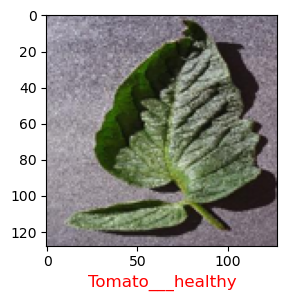

In [14]:
import matplotlib.pyplot as plt

# Label -> Index 
index_to_label = {idx: label for label, idx in label_to_index.items()}

def plot_sample(X, y, index):
    plt.figure(figsize=(15, 3))
    plt.imshow(X[index])

    
    class_name = index_to_label[y[index]]  # Index'e karşılık gelen label ismini alıyoruz
    plt.xlabel(class_name, fontsize=12, color="red")

    plt.show()

# Sample Showing
plot_sample(X, y, 12)  # 12th image is healthy tomato leaf


In [15]:
import numpy as np

# Saving for CNN Model
np.save("X_data.npy", X)
np.save("y_data.npy", y)
